In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [20]:
from PIL import UnidentifiedImageError, Image
import os

root_dir = os.path.expanduser('/Deep/catvsdog/PetImages')
for subdir, dirs, files in os.walk(root_dir):
    for file in files:
        file_path = os.path.join(subdir, file)
        try:
            img = Image.open(file_path)
            img.verify()
        except (UnidentifiedImageError, OSError):
            print(f"Deleting corrupt image: {file_path}")
            os.remove(file_path)

In [21]:
classes = ['Cat', 'Dog', 'Hare']

for cls in classes:
    class_dir = os.path.join(root_dir, cls)
    num_images = len([file for file in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, file))])
    print(f"{cls}: {num_images} images")

Cat: 12499 images
Dog: 12499 images
Hare: 1356 images


In [22]:
data_dir = '/Deep/catvsdog/PetImages'

In [23]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [24]:
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

In [25]:
from torch.utils.data import random_split

dataSize = len(dataset)
trSize = int(0.7 * dataSize)
teSize = dataSize - trSize

train_dataset, test_dataset = random_split(dataset, [trSize, teSize])

In [26]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [27]:
print(dataset.classes)

['Cat', 'Dog', 'Hare']


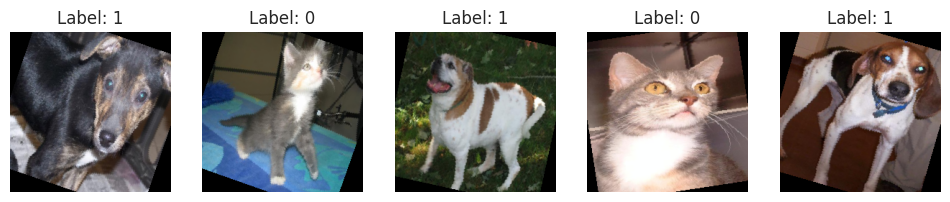

In [28]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

fig, axes = plt.subplots(1, 5, figsize=(12, 6))
for i in range(5):
    img = images[i].permute(1, 2, 0).numpy()
    img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    img = img.clip(0, 1)
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis('off')
plt.show()


In [29]:
class CatDogCNN(nn.Module):
    def __init__(self):
        super(CatDogCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool = (nn.MaxPool2d(kernel_size=2, stride=2))
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CatDogCNN().to(device)

class_counts = [12499, 12499, 1356]
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
class_weights = class_weights.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [31]:
trSize, teSize

(18447, 7907)

In [32]:
for epoch in range(8):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{8}, Loss: {loss:.4f}')

print("Training Finished!")

Epoch 1/8, Loss: 0.7952
Epoch 2/8, Loss: 0.5847
Epoch 3/8, Loss: 0.7714
Epoch 4/8, Loss: 0.4625
Epoch 5/8, Loss: 0.5968
Epoch 6/8, Loss: 0.4009
Epoch 7/8, Loss: 0.6412
Epoch 8/8, Loss: 0.4554
Training Finished!


In [33]:
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 78.39%


In [34]:
image = Image.open(os.path.expanduser('/Deep/dog.jpeg'))

img = transform(image).unsqueeze(0).to(device)

model.eval()
output = model(img)
_, predicted_class = torch.max(output, 1)
print("Predicted class:", predicted_class.item())

Predicted class: 1


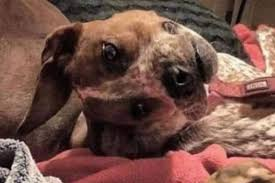

In [19]:
image